In [2098]:
import random

def random_nonzero_elt(F, elt):
    e = 0
    while (e + elt) == elt:
        e = F.random_element()
    return e

# q-ary noisy channel producing t errors
def channel_t_errors(y, t):
    ylen = y.length()
    K = y.base_ring()
    err_pos = Subsets(ylen - 1, t).random_element()
    return vector(K, [y[i] + random_nonzero_elt(K, y[i]) if i in err_pos else y[i] for i in range(ylen)])

In [2099]:
# Code de Reed Solomon généralisé (vecteur y=[1]*n par défaut, les éléments doivent être inversibles dans le sous groupe multiplicatif de GF(q))
# on se ramène à un code de Reed Solomon simple pour le décodage
# les points d'évaluation sont w=(1,g^2,...,g^(n-1)) avec <g>=Fq* un générateur par défaut
class GeneralizedReedSolomon:
    # TODO: pour initialiser soi-même w il faudrait avoir accès à K.<g>=GF(q)!
    def __init__(self, q, n, k, y=None, w=None):
        if y is None:
            y = [1] * n
        assert(len(y) == n)
        
        assert(n <= q)
        assert(k <= n)
            
        # paramètres du code
        self.q = q
        self.n = n
        self.k = k
        self.d = self.n - self.k + 1 # distance minimale
        
        self.t = floor((n - k) / 2) # nombre d'erreurs corrigibles
        
        # Corps fini K à q éléments et g un élément primitif (donc d'ordre q-1)
        K.<g> = GF(q)
        self.K = K
        self.g = g
        
        if w is None:
            # Le vecteur des points d'évaluation du code
            w = [g^i for i in range(self.n)]
        
        assert(len(set(w)) == n) # n points d'évaluation distincts
        self.w = vector(self.K, w)
        
        # Coeffs (appartenant à (Fq)*) d'un code de RS généralisé, et le vecteur des coeffs inversés
        self.y = vector(self.K, y)
        self.y_inv = vector(self.K, [e^(-1) for e in self.y])
        
        # Anneau des polys univariés sur K
        R_x.<x> = K[]
        self.R_x = R_x
        self.x = x
        
        # Anneau des polys bivariés sur K
        R_XY.<X, Y> = K[]
        self.R_XY = R_XY
        self.X = X
        self.Y = Y
        
    def encode(self, m):
        # Note: on aurait pu prendre self.w un sous-groupe multiplicatif de (F_q)* des racines 2^r-ème de l'unité suffisamment grand
        # pour y appliquer une transformée de Fourier rapide (évaluation en O(n log n)), au lieu de O(k n) pour l'encodage
        p = self.R_x(m.list())
        return vector(self.K, [self.y[i] * p(self.w[i]) for i in range(self.n)])
    
    def BerlekampWelch(self, u):
        # n contraintes linéaires
        # (deg A + 1) + (deg B + 1) variables = (n - t) + t + 1 = n + 1 variables
        M = matrix(self.K, self.n, self.n + 1)
        
        # On se ramène à un code de Reed-Solomon (pas un GRS)
        u = u.pairwise_product(self.y_inv)
        
        for i in range(self.n):  # n equations linéaires
            x_i = self.w[i]
            for j in range(self.t + 1): # u_i A(x_i)
                M[i, j] = u[i] * x_i^j
            for j in range(self.n - self.t): # -B(x_i)
                M[i, self.t + 1 + j] = -x_i^j
                
        coeffs = M.right_kernel().basis_matrix().rows() # résolution du système d'equations linéaires
        if coeffs == []:
            return None
        coeffs = coeffs[0]
        
        A = self.R_x(coeffs[:self.t + 1].list())
        B = self.R_x(coeffs[self.t + 1:self.n + 1].list())
        root = (B // A).list()
        
        # Parfois, comme le nombre de variables est plus grand que n, lorsque le mot de code commence par des zéros,
        # il faut padder le résultat par des 0 pour obtenir le mot de code
        while len(root) < self.k:
            root.append(0)
        return vector(self.K, root)
    
    def BerlekampMassey(self, u):
        # On se ramène à un code de Reed-Solomon (pas un GRS)
        u = u.pairwise_product(self.y_inv)
        
        # Construction du polynôme interpolateur de Lagrange U
        points = [] # points à interpoler
        Prod = 1 # le produit paramètre de Berlekamp Massey tel que C*Prod + A*U = B et B = pgcd(Prod, U)
        for i in range(self.n):
            x_i = self.w[i]
            points.append((x_i, u[i]))
            Prod *= (self.x - x_i)
        U = self.R_x.lagrange_polynomial(points)
        
        # Euclide étendu arrété prématurément dès que B_{i+1} < n - t
        # On pose pour k=0..2 les variables Ak := A_{i+k}, Bk := B_{i+k}, Ck := C_{i+k}
        (C0, A0, B0) = (1, 0, Prod)
        (C1, A1, B1) = (0, 1, U)
        while B1.degree() >= self.n - self.t:
            Q = B0 // B1
            B2 = B0 % B1
            A2 = A0 - Q * A1
            C2 = C0 - Q * C1
            (A0, B0, C0) = (A1, B1, C1)
            (A1, B1, C1) = (A2, B2, C2)
            
        root = (B1 // A1).list()
        
        # Parfois, comme le nombre de variables est plus grand que n, lorsque le mot de code commence par des zéros,
        # il faut padder le résultat par des 0 pour obtenir le mot de code
        while len(root) < self.k:
            root.append(0)
            
        return vector(self.K, root)
    
    # Retourne le degré d'un poly Q_j(X) de Q(X,Y)=sum_j Q_j(X) Y^j
    def __degQ_j_Sudan(self, r, j):
        return self.n - r - j * (self.k - 1) - 1
    
    # Initialisation de la matrice d'interpolation
    def __makeM_Sudan(self, u, r, l):
        lenQ_j = lambda j: 0 if self.__degQ_j_Sudan(r, j)+1 < 0 else self.__degQ_j_Sudan(r, j)+1
        ncol = sum([lenQ_j(j) for j in range(l + 1)]) #(l + 1)*(self.n/l + 1)
        
        M = matrix(self.K, self.n, ncol)
        for i in range(self.n): # n equations
            x_i = self.w[i]
            u_i = u[i]
            offset = 0
            for j in range(l + 1): # l + 1 polynômes Q_j
                degQ_j = self.__degQ_j_Sudan(r, j)
                if degQ_j < 0:
                    continue
                for k in range(degQ_j + 1):
                    M[i, offset + k] = u_i^j * x_i^k
                offset += degQ_j + 1
        return M
    
    # Distance de Hamming entre deux vecteurs
    def __hamming_dist(self, x, y):
        print("x,y=", x,y)
        y = y[:self.n]
        x = vector(self.K, x.list())
        return reduce(lambda a, b: a + 1 if b != 0 else a, (x - y).list(), 0)
    
    # Détermine le vecteur de L le plus proche de received_codeword au sens de la distance de Hamming
    def __argmin(self, L, received_codeword):
        argmin = L[0]
        dmin = self.__hamming_dist(self.encode(argmin), received_codeword)
        for i in range(1, len(L)):
            min_i = self.__hamming_dist(self.encode(L[i]), received_codeword)
            if min_i < dmin:
                dmin = min_i
                argmin = L[i]
        return argmin
    
    # self-explanatory
    def __pad_with_zeroes(self, r):
        r = r.list()
        while len(r) < self.k:
            r.append(0)
        return vector(self.K, r)
    
    def Sudan(self, u, r, l):
        print("u=", u)
        assert(l > 0)
        assert(r >= self.t)
        
        # On se ramène à un code de Reed-Solomon (pas un GRS)
        u = u.pairwise_product(self.y_inv)
        
        M = self.__makeM_Sudan(u, r, l)
        #print("M=", M)
        
        coeffs = M.right_kernel().basis_matrix().rows() # résolution du système d'equations linéaires
        if coeffs == []:
            print("interpolation: no solutions")
            return None
        coeffs = coeffs[0]
        #print("coeffs=",  coeffs)
        
        Q = 0
        offset = 0
        for j in range(l + 1):
            degQ_j = self.__degQ_j_Sudan(r, j) + 1
            v = coeffs[offset:offset + degQ_j]
            Q += sum([self.X^i * v[i] for i in range(len(v))]) * self.Y^j
            offset += degQ_j
                
        print("Q(Y)=", Q.polynomial(self.Y))
        
        # Résolution de Q(X,f(X))=0, on cherche donc les racines de Q en la variable Y
        roots = Q.polynomial(self.Y).roots()
        if roots == []:
            print("no roots")
            return None
        
        roots = list(map(lambda x: self.__pad_with_zeroes(x[0]), roots))
        
        print("roots=", roots)
        # maximum de vraissemblance
        return vector(self.K, self.__argmin(roots, u).list())
    
    def __degQ_j_GS(self, r, j, m):
        return m * (self.n - r) - j * (self.k - 1) - 1
    
    def __makeM_GS(self, noisy_codeword, r, l, m):
        # Comme Sudan, n contraintes linéaires Q(x_i, u_i)=0,
        # auquel on ajoute que Q(x+x_i,Y+u_i) n'a pas de monômes de degré < m (*) (ie. le poly R(X)=Q(X,f(X)) s'annule en x_i avec multiplicité m)
        # Le nb de contraintes implicites pour (*) est 2 parmi m+1
        # Donc au total on a n * (2 parmi m+1) eqs linéaires
        lenQ_j = lambda j: 0 if self.__degQ_j_GS(r, j, m)+1 < 0 else self.__degQ_j_GS(r, j, m)+1
        nvar = sum([lenQ_j(j) for j in range(l + 1)])
        neqs = self.n * m * (m + 1) / 2
        
        M = matrix(self.K, neqs, nvar)
        c = 0 # indice de la ligne courante
        for i in range(self.n):
            x_i = self.w[i]
            u_i = noisy_codeword[i]
            for u in range(m):
                for v in range(m - u):
                    offset = 0
                    for j in range(l + 1): # l + 1 polynômes Q_j
                        degQ_j = self.__degQ_j_GS(r, j, m)
                        if degQ_j < 0: # TODO: pas tip top, utiliser un while
                            continue
                        for k in range(degQ_j + 1):
                            col_idx = offset + k
                            if k >= u and j >= v:
                                M[c, col_idx] = binomial(k, u) * binomial(j, v) * x_i^(k - u) * u_i^(j - v)
                        offset += degQ_j + 1
                    c += 1
        #print("c=", c, " & neqs=", neqs, "\n") #OK! c == neqs
        return M
                                      
    def GuruswamiSudan(self, u, m, l, r):
        assert(m >= 1)
        assert(l > 0)
        assert(r >= self.t)
        
        # On se ramène à un code de Reed-Solomon (pas un GRS)
        u = u.pairwise_product(self.y_inv)
        
        M = self.__makeM_GS(u, r, l, m)
        #print("M=", M)
        
        coeffs = M.right_kernel().basis_matrix().rows() # résolution du système d'equations linéaires
        if coeffs == []:
            return None
        coeffs = coeffs[0]
        #print("coeffs=",  coeffs)
        
        # Construction du polynôme Q(X,Y)
        Q = 0
        offset = 0
        for j in range(l + 1):
            degQ_j = self.__degQ_j_GS(r, j, m) + 1
            v = coeffs[offset:offset + degQ_j]
            Q += sum([self.X^i * v[i] for i in range(degQ_j)]) * self.Y^j
            offset += degQ_j
            
        #print("Q(Y)=", Q.polynomial(self.Y))
        # Résolution de Q(X,f(X))=0, on cherche donc les racines de Q en la variable Y
        roots = Q.polynomial(self.Y).roots()
        if roots == []:
            return None
                
        roots = list(map(lambda x: self.__pad_with_zeroes(x[0]), roots))
        
        # maximum de vraissemblance
        return vector(self.K, self.__argmin(roots, u).list())

In [2100]:
rs1 = GeneralizedReedSolomon(256, 10, 4)

In [113]:
channel_t_errors(vector([rs1.g, rs1.g^1, 0, rs1.g^6]), 2)

(g, g, g^5 + g^3 + g^2 + 1, g^6)

## Calcul de distance minimale

In [1319]:
rs2 = GeneralizedReedSolomon(8, 6, 4)
rs2 = GeneralizedReedSolomon(5^2, 6, 4, [3, 1, 3, 3, 3, 3])
RS = VectorSpace(rs2.K, rs2.k)
wmin = rs2.n
for m in RS:
    w_tmp = rs2.encode(m).hamming_weight()
    if w_tmp > 0 and w_tmp < wmin:
        wmin = w_tmp
print(wmin)

3


## Encodage+décodage en caractéristique 2

In [1955]:
m = VectorSpace(rs1.K, rs1.k).random_element()

print("m = ", m)

m_enc = rs1.encode(m)
print("RS_encode(m) = ", m_enc)

# la distance minimale est 3 donc on peut corriger au max 1 erreur
noisy = channel_t_errors(m_enc, rs1.t)
print("Encoded + noise = ", noisy)

dec = rs1.BerlekampWelch(noisy)
print("Decoded = ", dec)
print("Success = ", m == dec)

dec = rs1.BerlekampMassey(noisy)
print("Decoded = ", dec)
print("Success = ", m == dec)

m =  (g^7 + g^6 + g^4 + g^3 + g^2 + g + 1, g^7 + g^6 + g^3 + g + 1, g^5 + g^4 + g^3 + 1, g^4 + g^2 + g + 1)
RS_encode(m) =  (g^5 + g^4 + g^3 + g, g^3, g^7 + g^6 + g^3 + g, g^3 + g^2 + g, g^6 + g^4 + g^3 + 1, g^7 + g^6 + g^5 + g^3 + 1, g^6 + g^5 + g^4 + g^3 + 1, g^3 + g + 1, g^6 + g^5, g^7 + g^5 + g^3 + 1)
Encoded + noise =  (g^5 + g^4 + g^3 + g, g^3, g^7 + g^6 + g^3 + g, g^3 + g^2 + g, g^7 + g^6 + g^5 + g^2, g^7 + g^6 + g^4 + g^2 + g + 1, g^6 + g^5 + g^4 + g^3 + 1, g^5 + g^4 + g^3 + 1, g^6 + g^5, g^7 + g^5 + g^3 + 1)
Decoded =  (g^7 + g^6 + g^4 + g^3 + g^2 + g + 1, g^7 + g^6 + g^3 + g + 1, g^5 + g^4 + g^3 + 1, g^4 + g^2 + g + 1)
Success =  True
Decoded =  (g^7 + g^6 + g^4 + g^3 + g^2 + g + 1, g^7 + g^6 + g^3 + g + 1, g^5 + g^4 + g^3 + 1, g^4 + g^2 + g + 1)
Success =  True


In [2129]:
m = VectorSpace(rs1.K, rs1.k).random_element()

print("m = ", m)

m_enc = rs1.encode(m)
print("RS_encode(m) = ", m_enc)


noisy = channel_t_errors(m_enc, rs1.t+1)
print("Encoded + noise = ", noisy)
   


dec = rs1.Sudan(noisy, rs1.t+1, 1000)
print("Decoded = ", dec)
print("Success = ", m == dec)

print("\n")

dec = rs1.GuruswamiSudan(noisy, 3, 10000, rs1.t+1)
print("Decoded = ", dec)
print("Success = ", m == dec)

m =  (g^6 + g^5 + g^4 + g^2 + g + 1, g^7 + g^6 + g^4 + 1, g^7 + g^6 + g^5 + g^4, g^6 + g^4 + g^3 + g^2 + g)
RS_encode(m) =  (g^3, g^7 + g^6 + g^5 + g^2 + 1, g^7 + g^5 + g^4 + 1, g^7 + g^4 + g^2 + g + 1, g^6 + g^3 + g, g^6 + g^5 + g^4 + g^3 + g^2 + g + 1, g^6 + g^4 + g^2, g^7 + g^4 + g^3 + g^2 + g, 1, g^7 + g^5)
Encoded + noise =  (g^3, g^7 + g^6 + g^5 + g^2 + 1, g^7 + g^5 + g^4 + 1, g^7 + g^4 + g^2 + g + 1, g^6 + g^3 + g, g^6 + g^5 + g^4, g^6 + g^5 + g^4 + g^2 + g, g^7 + g^6 + g^5 + g^4, g^7 + g^5 + g^2 + g, g^7 + g^5)
u= (g^3, g^7 + g^6 + g^5 + g^2 + 1, g^7 + g^5 + g^4 + 1, g^7 + g^4 + g^2 + g + 1, g^6 + g^3 + g, g^6 + g^5 + g^4, g^6 + g^5 + g^4 + g^2 + g, g^7 + g^6 + g^5 + g^4, g^7 + g^5 + g^2 + g, g^7 + g^5)
interpolation: no solutions
Decoded =  None
Success =  False


x,y= (g^3, g^7 + g^6 + g^5 + g^2 + 1, g^7 + g^5 + g^4 + 1, g^7 + g^4 + g^2 + g + 1, g^6 + g^3 + g, g^6 + g^5 + g^4 + g^3 + g^2 + g + 1, g^6 + g^4 + g^2, g^7 + g^4 + g^3 + g^2 + g, 1, g^7 + g^5) (g^3, g^7 + g^6 + g^5 

## Caractéristique 5

In [2130]:
rs5 = GeneralizedReedSolomon(5^2, 10, 4, [3, 3, 1, 3, 2, 3, 3, 1, 2, 4])

In [2184]:
m = VectorSpace(rs5.K, rs5.k).random_element()

print("m = ", m, "t= ", rs5.t)

m_enc = rs5.encode(m)
print("RS_encode(m) = ", m_enc)

# la distance minimale est 3 donc on peut corriger au max 1 erreur
noisy = channel_t_errors(m_enc, rs5.t+1)
print("Encoded + noise = ", noisy)

dec = rs5.BerlekampWelch(noisy)
print("Decoded = ", dec)
print("Success = ", m == dec)

dec = rs5.BerlekampMassey(noisy)
print("Decoded = ", dec)
print("Success = ", m == dec)


dec = rs5.Sudan(noisy, rs1.t, 10)
print("Decoded = ", dec)
print("Success = ", m == dec)

dec = rs5.GuruswamiSudan(noisy, 3, 10, rs1.t+1)
print("Decoded = ", dec)
print("Success = ", m == dec)

m =  (2*g + 1, 2, 2*g + 3, 2*g + 2) t=  3
RS_encode(m) =  (3*g + 4, g + 3, 2*g + 4, 4*g + 4, 2*g + 1, 3*g + 2, 3*g + 4, g + 1, 3*g + 4, 4*g + 3)
Encoded + noise =  (3*g + 4, 0, 2*g + 4, 4*g + 4, 2*g + 1, 3*g + 2, 4, 2*g + 3, 0, 4*g + 3)
Decoded =  (2*g + 2, 4*g + 2, 3*g + 1, 4*g + 4)
Success =  False
Decoded =  (2*g + 2, 4*g + 2, 3*g + 1, 4*g + 4)
Success =  False
u= (3*g + 4, 0, 2*g + 4, 4*g + 4, 2*g + 1, 3*g + 2, 4, 2*g + 3, 0, 4*g + 3)
interpolation: no solutions
Decoded =  None
Success =  False
x,y= (3*g + 4, g + 3, 2*g + 4, 4*g + 4, 2*g + 1, 3*g + 2, 3*g + 4, g + 1, 3*g + 4, 4*g + 3) (g + 3, 0, 2*g + 4, 3*g + 3, g + 3, g + 4, 3, 2*g + 3, 0, g + 2)
Decoded =  (2*g + 1, 2, 2*g + 3, 2*g + 2)
Success =  True


u= (g^3 + g^2 + g, 1, g^3 + g^2 + 1, g^4 + 1, g^4 + g^2, g^4 + g^2 + g)
M= [                      1                       1                       1                       1                       1           g^3 + g^2 + g           g^3 + g^2 + g]
[                      1                       g                     g^2                     g^3                     g^4                       1                       g]
[                      1                     g^2                     g^4                 g^3 + g           g^3 + g^2 + 1           g^3 + g^2 + 1                 g^4 + 1]
[                      1                     g^3                 g^3 + g           g^4 + g^3 + g           g^3 + g^2 + g                 g^4 + 1         g^4 + g^3 + g^2]
[                      1                     g^4           g^3 + g^2 + 1           g^3 + g^2 + g       g^4 + g^3 + g + 1               g^4 + g^2             g^2 + g + 1]
[                      1                 g^2 + 1                 g^4 + 1 g^

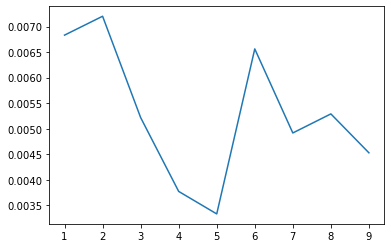

In [1352]:
import matplotlib.pyplot as plt
import time

johnson_bound = lambda q, d: (1 - 1/q) * (1 - sqrt(1 - d/(q - 1)))


q = 16
x = range(1, 10)
t = [0] * 9
for i in x:
    q *= 2
    rs1 = GeneralizedReedSolomon(q, 6, 4, [3, 1, 3, 3, 3, 3])
    m = VectorSpace(rs1.K, rs1.k).random_element()
    m_enc = rs1.encode(m)
    noisy = channel_t_errors(m_enc, rs1.t)
    start = time.time()
    rs1.Sudan(noisy, rs1.t, 10)
    t[i-1] = time.time() - start
    

plt.plot(x, t)
plt.show()

In [1318]:
johnson_bound(5,3).n()

0.400000000000000